### GPU지원

In [ ]:
from sympy.physics.continuum_mechanics.beam import numpy

from Scratch3.dezero.core import Parameter
!pip install cupy


  Using cached cupy-13.4.1.tar.gz (3.5 MB)
  Preparing metadata (setup.py) ... done
  error: subprocess-exited-with-error
  
  × python setup.py bdist_wheel did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for cupy
  Running setup.py clean for cupy
Failed to build cupy
ERROR: ERROR: Failed to build installable wheels for some pyproject.toml based projects (cupy)


In [2]:
import numpy as np
import cupy as cp

x = cp.arange(6).reshape(2, 3).astype('f')
print(x)

y = x.sum(axis=1)
print(y)

[[0. 1. 2.]
 [3. 4. 5.]]
[ 3. 12.]


In [3]:

n = np.array([1,2,3])
c = cp.asarray(n)
assert type(c) == cp.ndarray

c = cp.array([1,2,3])
n = cp.asnumpy(c)
assert type(n) == np.ndarray

print(c)
print(n)

[1 2 3]
[1 2 3]


In [4]:
x = np.array([1,2,3])
xp = cp.get_array_module(x)
assert xp == np

x = cp.array([1,2,3])
xp = cp.get_array_module(x)
assert xp == cp

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [23]:
%cd /content/drive/MyDrive/Colab\ Notebooks
!pwd

/content/drive/MyDrive/Colab Notebooks
/content/drive/MyDrive/Colab Notebooks


In [24]:
!pwd


/content/drive/MyDrive/Colab Notebooks


In [25]:
if '__file__' in globals():
    import os, sys
    sys.path.append(os.path.join(os.path.dirname(__file__), '.'))

import dezero
dezero.cuda.gpu_enable

/content/drive/MyDrive/Colab Notebooks/dezero/datasets.py:235: SyntaxWarning: "is" with a literal. Did you mean "=="?
  return fine_labels if label_type is 'fine' else coarse_labels


True

In [26]:
#/content/drive/MyDrive/Colab Notebooks/dezero

import numpy as np

gup_enable = True

try:
  import cupy as cp
  cupy = cp

except ImportError:
  cupy = None
  gup_enable = False

from dezero import Variable

In [ ]:
!pip install dezero

In [27]:
def get_array_module(x):
  if isinstance(x, Variable):
    x = x.data

  if not gpu_enable:
    return np
  xp = cp.get_array_module(x)
  return xp

def as_numpy(x):
  if isinstance(x, Variable):
    x = x.data

  if np.isscalar(x):
    return np.array(x)
  elif isinstance(x, np.ndarray):
    return x
  return cp.asnumpy(x)

def as_cupy(x):
  if isinstance(x, Variable):
    x = x.data


  if not gpu_enable:
    raise Exception('CuPy cannot be loaded. Install CuPy!')
  return cp.asarray(x)

In [29]:
from dezero.functions import Function
from dezero.functions import cos, sin

class Sin(Function):
  def forward(self, x):
    y = np.sin(x)
    return y

  def backward(self, gy):
    x, = self.inputs
    gx = gy * cos(x)
    return gx



In [30]:
class Sin(Function):
  def forward(self, x):
    #y = np.sin(x)
    xp = cuda.get_array_module(x)
    y = xp.sin(x)

    return y

  def backward(self, gy):
    x, = self.inputs
    gx = gy * cos(x)
    return gx

epoch: 1, loss: 1.9203, time: 2.8442[sec]
epoch: 2, loss: 1.2869, time: 2.6187[sec]
epoch: 3, loss: 0.9243, time: 2.5777[sec]
epoch: 4, loss: 0.7391, time: 2.5681[sec]
epoch: 5, loss: 0.6344, time: 2.8471[sec]
epoch: 6, loss: 0.5681, time: 3.0233[sec]
epoch: 7, loss: 0.5227, time: 3.0827[sec]
epoch: 8, loss: 0.4897, time: 2.8051[sec]
epoch: 9, loss: 0.4645, time: 2.7029[sec]
epoch: 10, loss: 0.4448, time: 2.5236[sec]


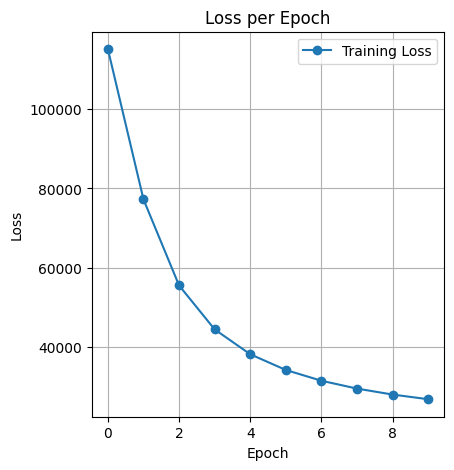

In [4]:
from sre_constants import MAX_REPEAT
import time
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero import DataLoader
from dezero.models import MLP
from dezero.datasets import MNIST
import matplotlib.pyplot as plt

max_epoch = 10
batch_size = 100

#train_set = dezero.datasets.MNIST(train=True)
train_set = MNIST(train=True)
train_loader = DataLoader(train_set, batch_size)
model = MLP((1000, 10))
optimizer = optimizers.SGD().setup(model)

if dezero.cuda.gpu_enable:
  train_loader.to_gpu()
  model.to_gpu()


epochs = []
losses = []

for epoch in range(max_epoch):
  start = time.time()
  sum_loss = 0

  for x, t in train_loader:
    y = model(x)
    loss = F.softmax_cross_entropy(y, t)
    model.cleargrads()
    loss.backward()
    optimizer.update()
    sum_loss += float(loss.data) * len(t)

  elapsed_time = time.time() - start
  print('epoch: {}, loss: {:.4f}, time: {:.4f}[sec]'.format(epoch + 1, sum_loss / len(train_set), elapsed_time))
  epochs.append(epoch)
  losses.append(sum_loss)


# Loss 플롯
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs, losses, marker='o', label='Training Loss')
plt.title('Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()


### 모델 저장 및 읽어오기

In [6]:
import numpy as np

x = np.array([1,2,3])
np.save('x.npy', x)

x = np.load('x.npy')
print(x)

[1 2 3]


In [10]:
x1 = np.array([1,2,3])
x2 = np.array([4,5,6])

np.savez('x.npz', x1=x1, x2=x2)

arrays = np.load('x.npz')
x1 = arrays['x1']
x2 = arrays['x2']
print(x1)
print(x2)

[1 2 3]
[4 5 6]


In [11]:
x1 = np.array([1,2,3])
x2 = np.array([4,5,6])
data = {'x1': x1, 'x2': x2}

np.savez('x.npz', **data)

arrays = np.load('x.npz')
x1 = arrays['x1']
x2 = arrays['x2']
print(x1)
print(x2)

[1 2 3]
[4 5 6]


In [20]:
from dezero import Layer
from dezero import Parameter
import numpy as np
import dezero.functions as F



layer = Layer()

l1 = Layer()
l1.p1 = Parameter(np.array(1))

layer.l1 = l1
layer.p2 = Parameter(np.array(2))
layer.p3 = Parameter(np.array(3))

layer


In [21]:
params_dict = {}
layer._flatten_params(params_dict)

print(params_dict)

{'l1/p1': variable(1), 'p3': variable(3), 'p2': variable(2)}


In [27]:
import os
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero import DataLoader
from dezero.models import MLP

max_epoch = 3
batch_size = 100


train_set = MNIST(train=True)
train_loader = DataLoader(train_set, batch_size)
model = MLP((1000, 10))
optimizer = optimizers.SGD().setup(model)

if os.path.exists('mlp.npz'):
    model.load_weights('mlp.npz')

for epoch in range(max_epoch):
    sum_loss = 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        sum_loss += float(loss.data) * len(t)

    print('epoch: {}, loss: {:.4f}'.format(epoch + 1, sum_loss / len(train_set)))

print("first execute")
model.save_weights('mlp.npz')

epoch: 1, loss: 1.9107
epoch: 2, loss: 1.2801
epoch: 3, loss: 0.9224
first execute


In [31]:
import os
import dezero
import dezero.functions as F
from dezero import optimizers
from dezero import DataLoader
from dezero.models import MLP

max_epoch = 3
batch_size = 100


train_set = MNIST(train=True)
train_loader = DataLoader(train_set, batch_size)
model = MLP((1000, 10))
optimizer = optimizers.SGD().setup(model)

if os.path.exists('mlp.npz'):
    model.load_weights('mlp.npz')

for epoch in range(max_epoch):
    sum_loss = 0

    for x, t in train_loader:
        y = model(x)
        loss = F.softmax_cross_entropy(y, t)
        model.cleargrads()
        loss.backward()
        optimizer.update()
        sum_loss += float(loss.data) * len(t)

    print('epoch: {}, loss: {:.4f}'.format(epoch + 1, sum_loss / len(train_set)))

model.save_weights('mlp.npz')

epoch: 1, loss: 0.4041
epoch: 2, loss: 0.3945
epoch: 3, loss: 0.3863


### 드롭아웃과 테스트 모드

In [38]:
import numpy as np

dropout_ratio = 0.6
x = np.ones(10)

mask = np.random.rand(10) > dropout_ratio
y = x * mask

print(x)
print(mask)
print(y)

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[ True  True  True False  True  True  True False False False]
[1. 1. 1. 0. 1. 1. 1. 0. 0. 0.]


In [46]:
mask = np.random.rand(*x.shape) > dropout_ratio
y = x * mask
print(y)

scalc = 1 - dropout_ratio
y = x * scalc
print(y)
print(scalc)
print(dropout_ratio)

[1. 0. 0. 1. 0. 0. 0. 1. 0. 0.]
[0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4 0.4]
0.4
0.6


In [47]:
scalc = 1 - dropout_ratio
mask = np.random.rand(*x.shape) > dropout_ratio
y = x * mask / scalc
print(y)

y = x
print(y)

[2.5 2.5 0.  0.  0.  0.  0.  0.  0.  0. ]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


In [48]:
import numpy as np
from dezero import test_mode
import dezero.functions as F

x = np.ones(5)
print(x)

y = F.dropout(x)
print(y)

with test_mode():
    y = F.dropout(x)
    print(y)

[1. 1. 1. 1. 1.]
variable([0. 0. 2. 0. 2.])
variable([1. 1. 1. 1. 1.])


### CNN 메커니즘 (1)

In [50]:
def get_conv_outsize(input_size, kernel_size,stride=1, pad=0):
    return (input_size + 2 * pad - kernel_size)

In [51]:
H, W = 4,4
KH, KW = 3,3
SH, SW = 1,1
PH, PW = 1,1

OH = get_conv_outsize(H, KH, SH, PH)
OW = get_conv_outsize(W, KW, SW, PW)
print(OH, OW)

4 4


### conv2d 함수와 pooling 함수

In [52]:
import numpy as np
import dezero.functions as F

x1 = np.random.randn(1, 3, 7, 7)
col1= F.im2col(x1, kernel_size=5, stride=1, pad=0, to_matrix=True)
print(col1.shape)

x2 = np.random.randn(10, 3, 7, 7)
kernel_size = (5,5)
stride = (1,1)
pad = (0, 0)
col2 = F.im2col(x2, kernel_size=kernel_size, stride=stride, pad=pad, to_matrix=True)
print(col2.shape)

(9, 75)
(90, 75)


In [53]:
from dezero.utils import pair

print(pair(1))
print(pair((1, 2)))

(1, 1)
(1, 2)


In [70]:
import numpy as np
from dezero import Variable
import dezero.functions as F

N, C, H, W = 1, 5, 15, 15
OC, (KH, KW) = 8, (3, 3)

x = Variable(np.random.randn(N, C, H, W))

W = np.random.randn(OC, C, KH, KW)
y = F.conv2d_simple(x, W, b=None, stride=1, pad=1)
y.backward()

print(x.shape)
print(x.grad.shape)

(1, 5, 15, 15)
(1, 5, 15, 15)


In [68]:
import numpy as np
from dezero import Variable
import dezero.functions as F


# im2col
x1 = np.random.rand(1, 3, 7, 7)
col1 = F.im2col(x1, kernel_size=5, stride=1, pad=0, to_matrix=True)
print(col1.shape)  # (9, 75)

x2 = np.random.rand(10, 3, 7, 7)  # 10個のデータ
kernel_size = (5, 5)
stride = (1, 1)
pad = (0, 0)
col2 = F.im2col(x2, kernel_size, stride, pad, to_matrix=True)
print(col2.shape)  # (90, 75)


# conv2d
N, C, H, W = 1, 5, 15, 15
OC, (KH, KW) = 8, (3, 3)
x = Variable(np.random.randn(N, C, H, W))
W = np.random.randn(OC, C, KH, KW)
y = F.conv2d_simple(x, W, b=None, stride=1, pad=1)
y.backward()
print(y.shape)  # (1, 8, 15, 15)
print(x.grad.shape)  # (1, 5, 15, 15)

(9, 75)
(90, 75)
(1, 8, 15, 15)
(1, 5, 15, 15)


### VGG16

In [76]:
import dezero.functions_conv as F
import dezero.layers as L
from dezero import Variable, Model

class VGG16(Model):
    def __init__(self):
        super().__init__()

        self.conv1_1 = L.Conv2d(64, kernel_size=3, stride=1, pad=1)
        self.conv1_2 = L.Conv2d(64, kernel_size=3, stride=1, pad=1)
        self.conv2_1 = L.Conv2d(128, kernel_size=3, stride=1, pad=1)
        self.conv2_2 = L.Conv2d(128, kernel_size=3, stride=1, pad=1)
        self.conv3_1 = L.Conv2d(256, kernel_size=3, stride=1, pad=1)
        self.conv3_2 = L.Conv2d(256, kernel_size=3, stride=1, pad=1)
        self.conv3_3 = L.Conv2d(256, kernel_size=3, stride=1, pad=1)
        self.conv4_1 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.conv4_2 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.conf4_3 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.conv5_1 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.conv5_2 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.conv5_3 = L.Conv2d(512, kernel_size=3, stride=1, pad=1)
        self.fc6 = L.Linear(4096)
        self.fc7 = L.Linear(4096)
        self.fc8 = L.Linear(1000)

    def forward(self, x):
        x = F.relu(self.conv1_1(x))
        x = F.relu(self.conv1_2(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv2_1(x))
        x = F.relu(self.conv2_2(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv3_1(x))
        x = F.relu(self.conv3_2(x))
        x = F.relu(self.conv3_3(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv4_1(x))
        x = F.relu(self.conv4_2(x))
        x = F.relu(self.conf4_3(x))
        x = F.pooling(x, 2, 2)
        x = F.relu(self.conv5_1(x))
        x = F.relu(self.conv5_2(x))
        x = F.relu(self.conv5_3(x))
        x = F.pooling(x, 2, 2)
        x = F.reshape(x, (x.shape[0], -1))
        x = F.dropout(F.relu(self.fc6(x)))
        x = F.dropout(F.relu(self.fc7(x)))
        x = self.fc8(x)
        return x

Downloading: vgg16.npz
[##############################] 100.00% Done


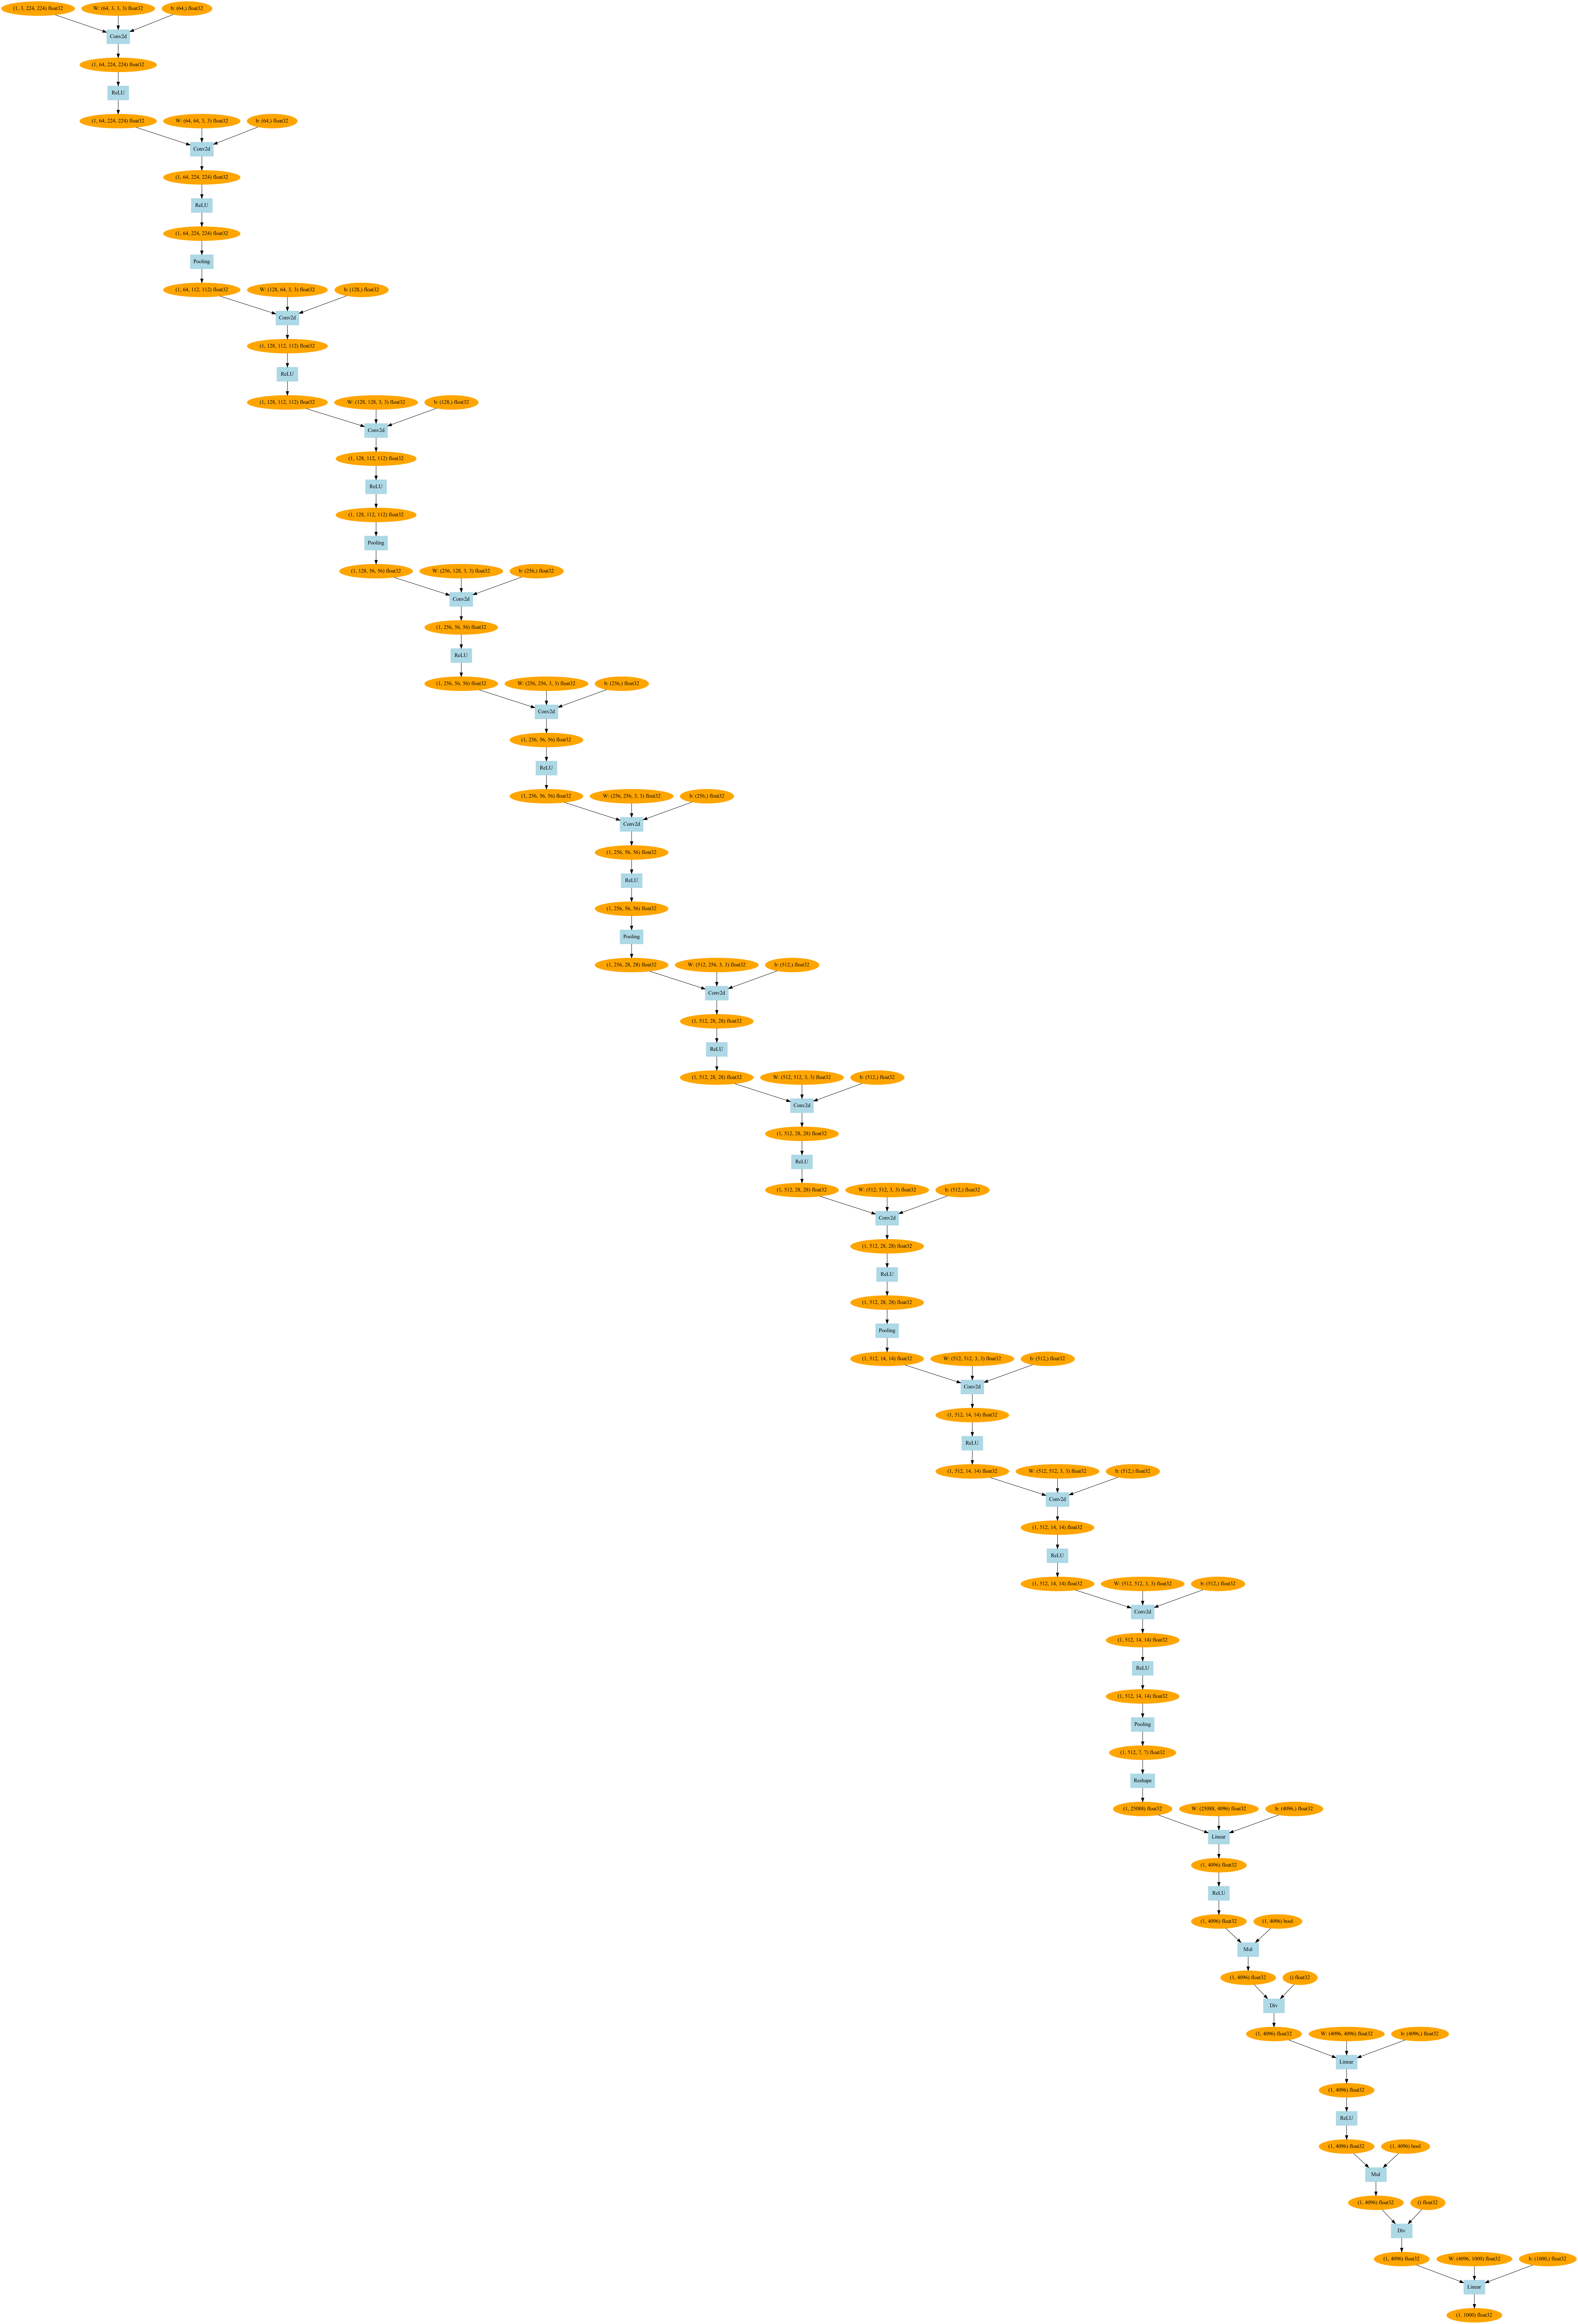

In [77]:
import numpy as np
from dezero.models import VGG16

model = VGG16(pretrained=True)

x= np.random.randn(1, 3, 224, 224).astype(np.float32)
model.plot(x)

In [80]:
import numpy as np
from PIL import Image
import dezero
from dezero.models import VGG16

url = 'https://github.com/oreilly-japan/deep-learning-from-scratch-3/raw/images/zebra.jpg'
img_path = dezero.utils.get_file(url)
img = Image.open(img_path)
img.show()


In [81]:
x = VGG16.preprocess(img)
print(type(x), x.shape)

<class 'numpy.ndarray'> (3, 224, 224)


In [83]:
import numpy as np
from PIL import Image
import dezero
from dezero.models import VGG16
from dezero.datasets import ImageNet


url = 'https://github.com/oreilly-japan/deep-learning-from-scratch-3/raw/images/zebra.jpg'
img_path = dezero.utils.get_file(url)
img = Image.open(img_path)

x = VGG16.preprocess(img)
x = x[np.newaxis]

model = VGG16(pretrained=True)
with dezero.test_mode():
    y = model(x)
predict_id = np.argmax(y.data)

model.plot(x, to_file='vgg.pdf')
labels = ImageNet.labels()
print(labels[predict_id])


Downloading: imagenet1000_clsidx_to_labels.txt
[##############################] 100.00% Done
zebra


### RNN을 활용한 시계열 데이터 처리

In [84]:
import numpy as np
import dezero.layers as L

rnn = L.RNN(10)
x = np.random.randn(1,1)
h = rnn(x)
print(h.shape)

(1, 10)


In [89]:
from dezero import Model
import dezero.functions as F
import dezero.layers as L

class SimpleRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.rnn = L.RNN(hidden_size)
        self.fc = L.Linear(out_size)

    def reset_state(self):
        self.rnn.reset_state()

    def forward(self, x):
        h = self.rnn(x)
        y = self.fc(h)
        return y


seq_data = [np.random.randn(1, 1) for _ in range(1000)]
xs = seq_data[0:-1]
ts = seq_data[1:]

model = SimpleRNN(10, 1)

loss, cnt = 0, 0
for x, t in zip(xs, ts):
    #model.reset_state()
    y = model(x)
    loss += F.mean_squared_error(y, t)
    cnt += 1

    if cnt == 2:
        model.cleargrads()
        loss.backward()
        break

999
(array([-0.02870125]), array([-0.00063772]))
(array([-0.00063772]), array([0.00780804]))
(array([0.00780804]), array([0.0131677]))


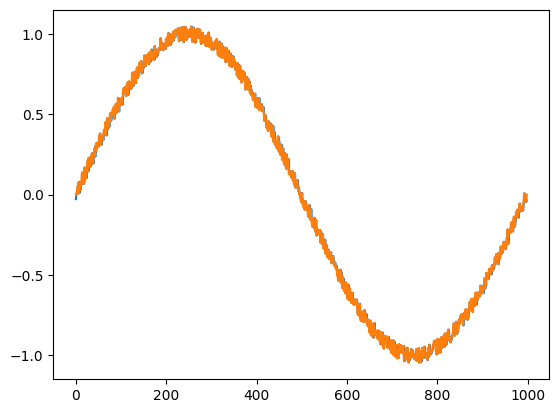

In [94]:
import numpy as np
import matplotlib.pyplot as plt
import dezero
from dezero.datasets import SinCurve


train_set = SinCurve(train=True)
print(len(train_set))
print(train_set[0])
print(train_set[1])
print(train_set[2])

xs = [example[0] for example in train_set]
ts = [example[1] for example in train_set]
plt.plot(np.arange(len(xs)), xs, label='xs')
plt.plot(np.arange(len(ts)), ts, label='ts')
plt.show()


| epoch 1 | loss 0.162366
| epoch 2 | loss 0.061414
| epoch 3 | loss 0.020608
| epoch 4 | loss 0.011157
| epoch 5 | loss 0.005241
| epoch 6 | loss 0.002453
| epoch 7 | loss 0.002037
| epoch 8 | loss 0.001628
| epoch 9 | loss 0.001833
| epoch 10 | loss 0.001813
| epoch 11 | loss 0.002367
| epoch 12 | loss 0.003446
| epoch 13 | loss 0.005123
| epoch 14 | loss 0.006120
| epoch 15 | loss 0.005228
| epoch 16 | loss 0.004273
| epoch 17 | loss 0.004319
| epoch 18 | loss 0.005052
| epoch 19 | loss 0.005841
| epoch 20 | loss 0.005963
| epoch 21 | loss 0.005409
| epoch 22 | loss 0.004865
| epoch 23 | loss 0.004698
| epoch 24 | loss 0.004791
| epoch 25 | loss 0.004882
| epoch 26 | loss 0.004797
| epoch 27 | loss 0.004573
| epoch 28 | loss 0.004389
| epoch 29 | loss 0.004352
| epoch 30 | loss 0.004434
| epoch 31 | loss 0.004539
| epoch 32 | loss 0.004615
| epoch 33 | loss 0.005059
| epoch 34 | loss 0.006257
| epoch 35 | loss 0.008173
| epoch 36 | loss 0.037736
| epoch 37 | loss 0.052820
| epoch 38

/var/folders/8l/dq9nhgmx5gj01xrwhwzb41s40000gn/T/ipykernel_22049/1158494385.py:65: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_list.append(float(y.data))


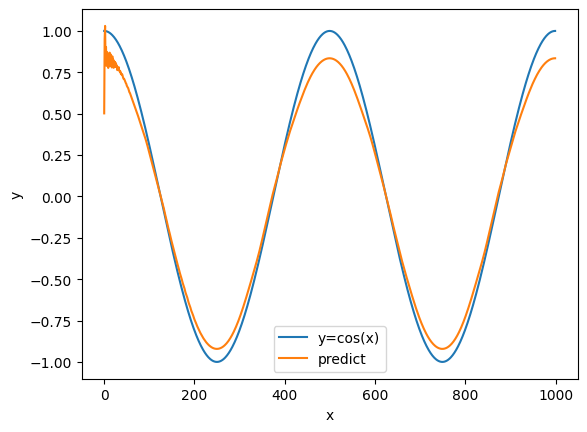

In [92]:

# Hyperparameters
max_epoch = 100
hidden_size = 100
bptt_length = 30

train_set = SinCurve(train=True)
seqlen = len(train_set)



model = SimpleRNN(hidden_size, 1)
optimizer = dezero.optimizers.Adam().setup(model)

# Start training.
for epoch in range(max_epoch):
    model.reset_state()
    loss, count = 0, 0

    for x, t in train_set:
        x = x.reshape(1, 1)
        y = model(x)
        loss += F.mean_squared_error(y, t)
        count += 1

        if count % bptt_length == 0 or count == seqlen:
            model.cleargrads()
            loss.backward()
            loss.unchain_backward()
            optimizer.update()

    avg_loss = float(loss.data) / count
    print('| epoch %d | loss %f' % (epoch + 1, avg_loss))

# Plot
xs = np.cos(np.linspace(0, 4 * np.pi, 1000))
model.reset_state()
pred_list = []

with dezero.no_grad():
    for x in xs:
        x = np.array(x).reshape(1, 1)
        y = model(x)
        pred_list.append(float(y.data))

plt.plot(np.arange(len(xs)), xs, label='y=cos(x)')
plt.plot(np.arange(len(xs)), pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

### LSTM, Dataloader

| epoch 1 | loss 0.704062
| epoch 2 | loss 0.560185
| epoch 3 | loss 0.436305
| epoch 4 | loss 0.331832
| epoch 5 | loss 0.246286
| epoch 6 | loss 0.179054
| epoch 7 | loss 0.129163
| epoch 8 | loss 0.095142
| epoch 9 | loss 0.074864
| epoch 10 | loss 0.065524
| epoch 11 | loss 0.063983
| epoch 12 | loss 0.067329
| epoch 13 | loss 0.073060
| epoch 14 | loss 0.078979
| epoch 15 | loss 0.083242
| epoch 16 | loss 0.084644
| epoch 17 | loss 0.082831
| epoch 18 | loss 0.078207
| epoch 19 | loss 0.071645
| epoch 20 | loss 0.064164
| epoch 21 | loss 0.056692
| epoch 22 | loss 0.049928
| epoch 23 | loss 0.044299
| epoch 24 | loss 0.039975
| epoch 25 | loss 0.036923
| epoch 26 | loss 0.034976
| epoch 27 | loss 0.033893
| epoch 28 | loss 0.033412
| epoch 29 | loss 0.033289
| epoch 30 | loss 0.033324
| epoch 31 | loss 0.033362
| epoch 32 | loss 0.033304
| epoch 33 | loss 0.033095
| epoch 34 | loss 0.032717
| epoch 35 | loss 0.032181
| epoch 36 | loss 0.031514
| epoch 37 | loss 0.030751
| epoch 38

/var/folders/8l/dq9nhgmx5gj01xrwhwzb41s40000gn/T/ipykernel_22049/483868732.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  pred_list.append(float(y.data))


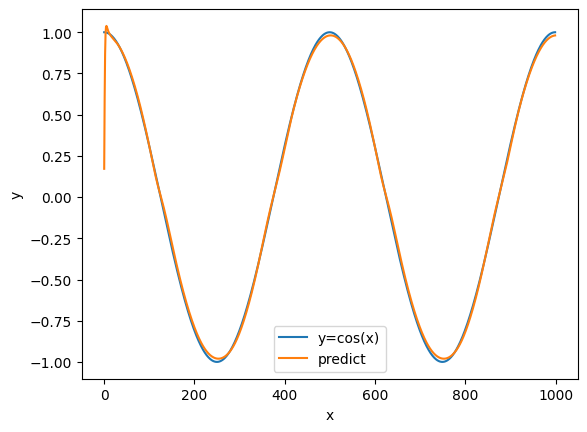

In [95]:
import numpy as np
import matplotlib.pyplot as plt
import dezero
from dezero.datasets import SinCurve
from dezero import Model
from dezero import SeqDataLoader
import dezero.functions as F
import dezero.layers as L


# Hyperparameters
max_epoch = 100
batch_size = 30
hidden_size = 100
bptt_length = 30

train_set = SinCurve(train=True)
dataloader = SeqDataLoader(train_set, batch_size = batch_size)
seqlen = len(train_set)

class BatterRNN(Model):
    def __init__(self, hidden_size, out_size):
        super().__init__()
        self.rnn = L.LSTM(hidden_size)
        self.fc = L.Linear(out_size)

    def reset_state(self):
        self.rnn.reset_state()

    def forward(self, x):
        h = self.rnn(x)
        y = self.fc(h)
        return y

model = BatterRNN(hidden_size, 1)
optimizer = dezero.optimizers.Adam().setup(model)

# Start training.
for epoch in range(max_epoch):
    model.reset_state()
    loss, count = 0, 0

    for x, t in dataloader:
        y = model(x)
        loss += F.mean_squared_error(y, t)
        count += 1

        if count % bptt_length == 0 or count == seqlen:
            model.cleargrads()
            loss.backward()
            loss.unchain_backward()
            optimizer.update()

    avg_loss = float(loss.data) / count
    print('| epoch %d | loss %f' % (epoch + 1, avg_loss))

# Plot
xs = np.cos(np.linspace(0, 4 * np.pi, 1000))
model.reset_state()
pred_list = []

with dezero.no_grad():
    for x in xs:
        x = np.array(x).reshape(1, 1)
        y = model(x)
        pred_list.append(float(y.data))

plt.plot(np.arange(len(xs)), xs, label='y=cos(x)')
plt.plot(np.arange(len(xs)), pred_list, label='predict')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()